## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [2]:
# Downloading the data, if it does not exist, this could take some time... (148MB)
import urllib
import os
if not os.path.isfile('Data_8_faces_no_cut.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/l0ck0xddlaazhb9/Data_8_faces_no_cut.hdf5?dl=1",
    "Data_8_faces_no_cut.hdf5")
%ls -hl Data_8_faces_no_cut.hdf5

-rw-r--r-- 1 root root 148M Apr 13 09:16 Data_8_faces_no_cut.hdf5


In [3]:
h5f_X = h5py.File('Data_8_faces_no_cut.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_test_8_faces', 'X_train_8_faces', 'X_valid_8_faces', 'Y_test_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([ 250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

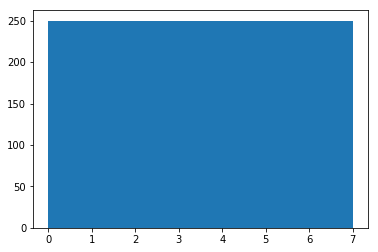

In [4]:
plt.hist(Y_train,bins=8)

(array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

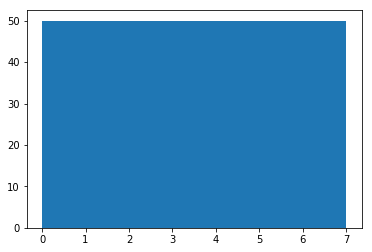

In [5]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

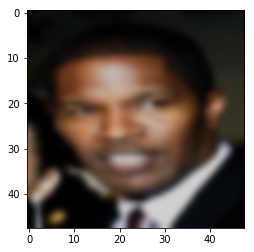

In [6]:
np.random.seed(seed=42)
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")

#### Normalization of the training and validationset.

In [7]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

In [8]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


Define the convertToOneHot function and convert the labels into the onehot encoding.

In [9]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [10]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [11]:
batch_size = 128
nb_classes = 8
nb_epoch = 50
img_rows, img_cols = 48, 48
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

In [12]:
print(Y_train[1])
print(Y_valid[1])

[0 0 0 1 0 0 0 0]
[0 0 0 0 0 1 0 0]


In [13]:
print(X_train.shape)
print(X_valid.shape)

(2000, 48, 48, 3)
(400, 48, 48, 3)


### Define the network

In [14]:
model = Sequential()
name = 'cnn'

model.add(Convolution2D(32, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',
                        padding='same',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(64, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())#macht einen vektor aus dem output
model.add(Dense(200,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dense(nb_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
model = Sequential()
name = 'cnn_dropout'

model.add(Convolution2D(32, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',
                        padding='same',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Flatten())#macht einen vektor aus dem output
model.add(Dense(200,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(nb_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model = Sequential()
name = 'cnn_dropout_batchnorm'

model.add(Convolution2D(32, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',
                        padding='same',
                        input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(32, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(64, (kernel_size[0], kernel_size[1]),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.3))

model.add(Flatten())#macht einen vektor aus dem output
model.add(Dense(200,kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(nb_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
__________

### Running a forward pass of the untrained network

In [18]:
model.evaluate(X_train[0:300],Y_train[0:300])

300/300 [==============================] - 8s      


[2.9587639204661049, 0.096666666666666665]

In [19]:
-np.log(1/8.)

2.0794415416798357

In [20]:
model.predict(X_train[0].reshape(1,48,48,3))

array([[ 0.02700992,  0.12098762,  0.05470027,  0.05319156,  0.09923304,
         0.03592772,  0.13450156,  0.47444826]], dtype=float32)

In [21]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

### Training the network

In [22]:
history=model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard])

Train on 2000 samples, validate on 400 samples
INFO:tensorflow:Summary name conv2d_9/kernel:0 is illegal; using conv2d_9/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_9/bias:0 is illegal; using conv2d_9/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/gamma:0 is illegal; using batch_normalization_1/gamma_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_10/kernel:0 is illegal; using conv2d_10/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_10/bias:0 is illegal; using conv2d_10/bias_0 instead.
INFO:tensorflow:Summary name batch_normalization_2/gamma:0 is illegal; using batch_normalizatio

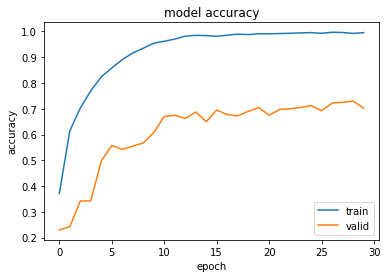

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

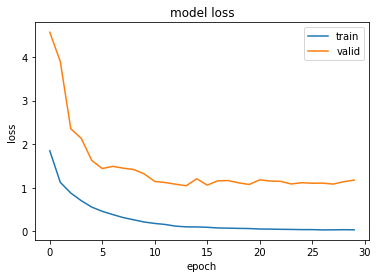

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [25]:
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)

(400, 48, 48, 3)
(400,)


In [26]:
X_test = (X_test - X_mean ) / (X_std + 0.0001)

In [27]:
model.predict(X_test[0].reshape(1,48,48,3))

array([[  6.75424235e-04,   3.88077676e-01,   4.59071045e-04,
          1.81109481e-03,   7.38953386e-05,   1.16122678e-01,
          4.62823212e-01,   2.99569201e-02]], dtype=float32)

In [28]:
preds=np.zeros([len(X_test),8])
for i in range(0,len(X_test)):
    preds[i]=model.predict(X_test[i].reshape(1,48,48,3))

In [29]:
pred=np.zeros([len(X_test)])
for i in range(0,len(X_test)):
    pred[i]=np.argmax(preds[i])

In [30]:
sum(pred==Y_test)/400.

0.70999999999999996

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, pred)

array([[35,  1,  2,  0,  0,  1, 11,  0],
       [ 1, 25,  3,  2,  8,  2,  6,  3],
       [ 1,  2, 41,  1,  0,  0,  2,  3],
       [ 2,  1,  3, 37,  2,  0,  4,  1],
       [ 0,  3,  0,  2, 44,  0,  1,  0],
       [ 2,  4,  1,  2,  1, 30,  8,  2],
       [ 1,  0,  2,  1,  1,  1, 43,  1],
       [ 4,  2,  3,  2,  3,  1,  6, 29]])